In [297]:
import scipy.stats as stats
from scipy.stats import chisquare
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import find_MAP
import theano.tensor
from IPython.core.pylabtools import figsize

#first we simulate some data to show that a split point can be found 
NUM_DRAWS = 10000
NUM_SAMPLES = 500
TRUE_PROPS_1 = [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]
TRUE_PROPS_2 = [0.10, 0.45, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.10]

TRUE_TAU = 550

def generate_data():
    data = np.zeros((NUM_SAMPLES,len(TRUE_PROPS_1)))
    for i in range(NUM_SAMPLES):
        if(i < TRUE_TAU):
            x = np.random.multinomial(NUM_DRAWS, TRUE_PROPS_1)
            data[i]=x
        else:
            x = np.random.multinomial(NUM_DRAWS, TRUE_PROPS_2)
            data[i]=x
    return data

In [298]:
def generate_props(k):
        alpha = np.ones(k)
        sum_ = 0
        for i in range(k):
            alpha[i] = np.random.uniform(0,10,1)
        x = np.random.dirichlet(alpha, 1).transpose()
        return x

In [299]:
#simulate data with random Dirichelts and random split points
def simulate_split_data(k):
    NUM_DRAWS = 10000
    NUM_SAMPLES = 500
    
    TRUE_PROPS_1 = generate_props(k)
    TRUE_PROPS_2 = generate_props(k)
    
    TP1 = np.reshape(TRUE_PROPS_1,k)
    TP2 = np.reshape(TRUE_PROPS_2,k)
    
    TRUE_TAU = np.random.randint(1,NUM_SAMPLES)
    print(TRUE_TAU)
    
    data = np.zeros((NUM_SAMPLES,len(TRUE_PROPS_1)))
    for i in range(NUM_SAMPLES):
        if(i < TRUE_TAU):
            x = np.random.multinomial(NUM_DRAWS, TP1)
            data[i]=x
        else:
            x = np.random.multinomial(NUM_DRAWS, TP2)
            data[i]=x
    return data

In [300]:
#sim_data = simulate_split_data(10)
sim_data = generate_data()

In [301]:
#setup a new random varibale for the split function for a dirichlet prior on the Multinomial

@theano.compile.ops.as_op(itypes=[t.lscalar, t.dvector, t.dvector],otypes=[t.dmatrix])
def dir_(tau=tau, props_1=props_1,props_2=props_2):
        
        out = np.zeros((len(sim_data[:]),len(sim_data[0])))
        out[:tau] = props_1
        out[tau:] = props_2
        
        return np.asmatrix(out)

In [305]:

num_alphas_per_dirichlet = 10 #the lenght (k) of the Multinomial in question

#setup the model object
with pm.Model() as VM_model:
    #set the variable for the Dirichlet prior's parameter (we assume this to be uniform and unimportant) 
    alphas_1 = np.ones(num_alphas_per_dirichlet)
    
    #set the random varibales as Dirichlets as priors for the Multinomial (before and after split)
    props_1 = pm.Dirichlet('props1', alphas_1)
    props_2 = pm.Dirichlet('props2', alphas_1)   
    
    #set the split point to be a random discrete varibale with assummed uniform distribution (no bias)
    tau = pm.DiscreteUniform("tau", lower=-1, upper=len(sim_data[:])+1)
    
    #create the deterministic variable but treated as random by MCMC
    y_hat = pm.Deterministic('y_hat',dir_(tau,props_1,props_2))
        
    #blend the observed data and the multinomial distribution for likelihood calcualtions    
    observed = pm.Multinomial('draws', p=y_hat, n=NUM_DRAWS, observed=sim_data)
    
    #run the model 
    #trace = pm.sample(10000, tune=500, step=pm.Metropolis())

/Users/matbutle/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [183]:
#first finf the MAP then use this as starting point
with VM_model:
    start = find_MAP(model=VM_model)
    trace = pm.sample(10000, tune=500, step=pm.Metropolis(),start=start)

100%|██████████| 10500/10500 [00:17<00:00, 596.45it/s]


In [306]:
with VM_model:
    trace = pm.sample(10000, tune=500, step=pm.Metropolis())

100%|██████████| 10500/10500 [00:20<00:00, 514.44it/s]


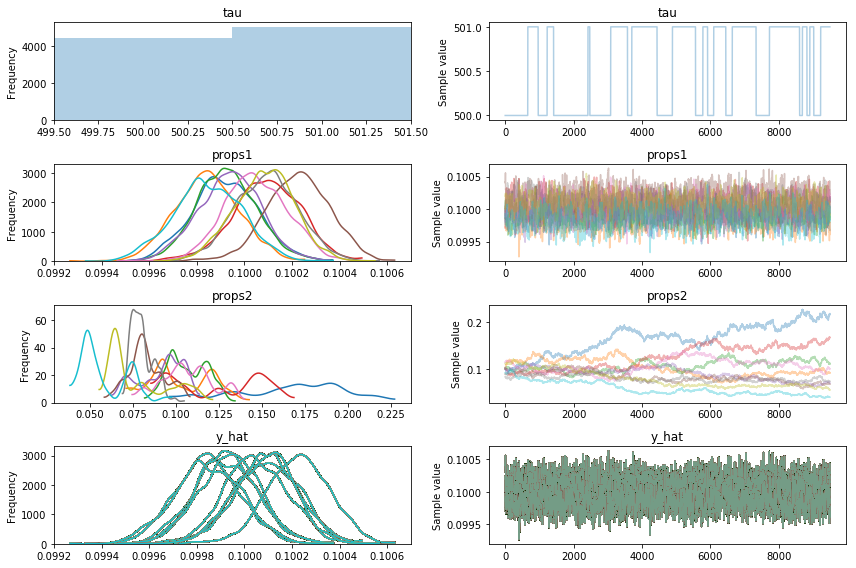

In [307]:
#plot data from the MCMC posteriors
pm.traceplot(trace[500:])
plt.show()

In [287]:
#some simple statistics from the posteriors 
def summarize(mcmc, field):
    results = mcmc[field]
    results = zip(*results)
    means = []
    stds = []
    for r in results:
        m = np.mean(r)
        v = np.std(r)
        means.append(m)
        stds.append(v)
    #means.append(1.0 - sum(means))
    print
    print("---")
    print(np.round_(means,decimals=4))
    return np.round_(means,decimals=4)
    #print(stds)

In [308]:
tau_samples = trace['tau']
props_1_samples = trace['props1']
props_2_samples = trace['props2']

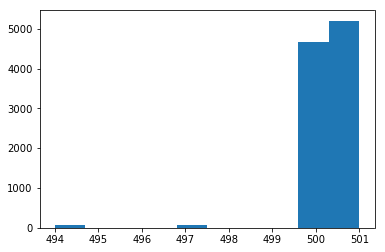

In [309]:
plt.hist(tau_samples)
plt.show()

In [290]:
stats.mode(tau_samples)

ModeResult(mode=array([250]), count=array([10000]))

In [291]:
p1mean = np.array(summarize(trace, "props1"))
p2mean = np.array(summarize(trace, "props2"))

---
[ 0.1004  0.0999  0.0999  0.1     0.1     0.1001  0.1     0.1     0.0999
  0.0999]
---
[ 0.0969  0.4384  0.0507  0.0549  0.0518  0.0524  0.0541  0.0508  0.0511
  0.0989]


In [293]:
def chiSquareTest(p1, p2):
    p1s = np.round_(np.array(p1)*1000,decimals=0)
    p2s = np.round_(np.array(p2)*1000,decimals=0)
    cst = chisquare(p1s, f_exp=p2s)
    print((p1s))
    return cst.pvalue

In [294]:
chiSquareTest(p1mean,p2mean)

[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]


2.7967561851912517e-116